# Setup

In [1]:
%matplotlib notebook
LOG_PLOT = True

## Imports

In [2]:
from matplotlib import pyplot as plt
plt.style.use('seaborn-darkgrid')
import pandas as pd
from datetime import datetime

import requests
from json import loads, dumps

import os

## ECDC Data

In [3]:

# WORLD
def fetch_world():
    response = requests.get('https://opendata.ecdc.europa.eu/covid19/casedistribution/json')    
    json = response.json()
    df = pd.read_json(dumps(json['records']))   
    df['dateRep']=pd.to_datetime(df['dateRep'].astype(str), format='%d/%m/%Y')

    return df



def plot_country(geoId, roll_days=7, log=False):
    selection = df[df.geoId==geoId].sort_values(by=['year','month','day'], ascending=True)

    f,ax = plt.subplots()
    ax.plot(selection.dateRep, selection['cases'].rolling(roll_days).mean(), label=f'{roll_days} day average', marker='o', markersize=4, linestyle='--')
#     ax.xaxis.set_major_locator(plt.MaxNLocator(20))
    ax.xaxis.set_major_locator(plt.MaxNLocator(20))
    plt.xticks(rotation=45)
    ax.bar(selection.dateRep, selection['cases'],label='recorded',  alpha=0.6, color='C1')
    plt.legend(loc='best')
    if log:
        plt.yscale('log')
        
    plt.title(selection.iloc[0].countriesAndTerritories.replace('_', ' '))
    plt.tight_layout()

    return f



df = fetch_world()


## Austria - from Gesundheitsminesterium

In [4]:
# AUSTRIA
WEEKDAYS = ('Monday', 'Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday')

def fetch_Austria():
    df = pd.read_csv('https://info.gesundheitsministerium.at/data/Epikurve.csv', delimiter=';')
    weekday= []
    print(df.columns)
    for i, row in df.iterrows():
        day_num = datetime.strptime(row['time'], '%d.%m.%Y').weekday()
        weekday.append(day_num)
        
    df['weekday'] = weekday
    df['time']=pd.to_datetime(df['time'].astype(str), format='%d.%m.%Y')
#     .dt.strftime('%d/%m/%Y')

    return df

def plot_Austria(roll_days=7, log=False):
    df = fetch_Austria()
    f,ax = plt.subplots()
    ax.plot(df.time, df['tägliche Erkrankungen'].rolling(roll_days).mean(), label=f'{roll_days} day average', marker='o', markersize=4, linestyle='--')
    ax.xaxis.set_major_locator(plt.MaxNLocator(20))
    plt.xticks(rotation=45)
    ax.bar(df.time, df['tägliche Erkrankungen'],label='recorded',  alpha=0.6, color='C1')
    plt.legend(loc='best')
    plt.title('Positive COVID tests')
    if log:
        plt.yscale('log')
    plt.tight_layout()
    return f

df_at  = fetch_Austria()


Index(['time', 'tägliche Erkrankungen', 'Timestamp'], dtype='object')


## Aggregation Functions

In [14]:
import numpy as np
def rolling_avg(x):
    return np.round(x.iloc[-7:].mean())

def latest(x):
    return x.iloc[-1]

def last_7_days_sum(x):
    return x.iloc[-7:].sum()
    
    
def overview(selection):
    '''
    Returns 
    - sum,     
    - last_7_days_sum: sum in the last 7 days, 
    - rolling_avg:  rolling average for the last 7 days, 
    - latest, and 
    - max 
    values for cases and deaths
    '''
    return selection.sort_values(
        by=['year','month','day'], ascending=True).groupby("countriesAndTerritories").agg(
        {'cases': ['sum', last_7_days_sum,  rolling_avg, latest,  'max' ],
        'deaths': ['sum',  last_7_days_sum,  rolling_avg, latest,  'max' ],} ).sort_values(by= ('cases','last_7_days_sum'),ascending=False)
    

## DF Subsets

In [6]:
SELECTION =  df[df.geoId.isin(['AT', 'IN', 'US', 'UK', 'DE', 'IT', 'NL'])]
EU = df[df.continentExp=='Europe']
AMERICA = df[(df.continentExp=='America')]


# Overview

## Selected Countries

In [15]:
overview(SELECTION)

cases                                            \
                              sum last_7_days_sum rolling_avg latest    max   
countriesAndTerritories                                                       
India                     5992532          591913       84559  88600  97894   
United_States_of_America  7078798          313836       44834  45368  78427   
United_Kingdom             429277           38919        5560   6041   6873   
Netherlands                108521           16680        2383   2711   2776   
Germany                    284140           12725        1818   1410   6294   
Italy                      308104           11535        1648   1869   6557   
Austria                     42940            4992         713    623   1141   

                          deaths                                           
                             sum last_7_days_sum rolling_avg latest   max  
countriesAndTerritories                                                    
India                      94503            7751        1107   1124  2003  
United_States_of_America  204497            5239         748    723  4928  
United_Kingdom             41971             212          30     35  1224  
Netherlands                 6357              91          13     38   234  
Germany                     9457              71          10      5   315  
Italy                      35818             126          18     17   971  
Austria                      787              22           3      1    31

## Most cases in the last 7 days

### Europe

In [19]:
overview(EU).head(5)

cases                                            \
                             sum last_7_days_sum rolling_avg latest    max   
countriesAndTerritories                                                      
France                    527446           85252       12179  14412  16096   
Spain                     716481           76441       10920      0  31428   
Russia                   1143571           46320        6617   7523  11656   
United_Kingdom            429277           38919        5560   6041   6873   
Ukraine                   195504           22792        3256   3833   5863   

                        deaths                                           
                           sum last_7_days_sum rolling_avg latest   max  
countriesAndTerritories                                                  
France                   31700             426          61     39  2004  
Spain                    31232             737         105      0  1179  
Russia                   20225             886         127    169   312  
United_Kingdom           41971             212          30     35  1224  
Ukraine                   3903             387          55     76   129

### America

In [18]:
overview(AMERICA).head(5)

cases                                            \
                              sum last_7_days_sum rolling_avg latest    max   
countriesAndTerritories                                                       
United_States_of_America  7078798          313836       44834  45368  78427   
Brazil                    4717991          189751       27107  28378  69074   
Argentina                  702471           88826       12689  11249  17213   
Colombia                   806038           47640        6806   7721  13056   
Peru                       800142           37277        5325   5558  10143   

                          deaths                                           
                             sum last_7_days_sum rolling_avg latest   max  
countriesAndTerritories                                                    
United_States_of_America  204497            5239         748    723  4928  
Brazil                    141406            4874         696    869  1595  
Argentina                  15543            2838         405    335   573  
Colombia                   25296            1257         180    193   400  
Peru                       32142             773         110    105  3935

### World

In [20]:
overview(df).head(10)

cases                                            \
                              sum last_7_days_sum rolling_avg latest    max   
countriesAndTerritories                                                       
India                     5992532          591913       84559  88600  97894   
United_States_of_America  7078798          313836       44834  45368  78427   
Brazil                    4717991          189751       27107  28378  69074   
Argentina                  702471           88826       12689  11249  17213   
France                     527446           85252       12179  14412  16096   
Spain                      716481           76441       10920      0  31428   
Colombia                   806038           47640        6806   7721  13056   
Russia                    1143571           46320        6617   7523  11656   
Israel                     227100           43498        6214  11827  11827   
United_Kingdom             429277           38919        5560   6041   6873   

                          deaths                                           
                             sum last_7_days_sum rolling_avg latest   max  
countriesAndTerritories                                                    
India                      94503            7751        1107   1124  2003  
United_States_of_America  204497            5239         748    723  4928  
Brazil                    141406            4874         696    869  1595  
Argentina                  15543            2838         405    335   573  
France                     31700             426          61     39  2004  
Spain                      31232             737         105      0  1179  
Colombia                   25296            1257         180    193   400  
Russia                     20225             886         127    169   312  
Israel                      1441             215          31     36    71  
United_Kingdom             41971             212          30     35  1224

## Lowset number of new cases in the last 7 days

### Europe*

\*among countries with population of at least 1 million

In [22]:
overview(EU[EU.popData2019>1*10**6]).tail(5)

cases                                         deaths  \
                           sum last_7_days_sum rolling_avg latest  max    sum   
countriesAndTerritories                                                         
Lithuania                 4295             631          90    111  138     89   
Serbia                   33312             472          67     74  467    746   
Kosovo                   15425             423          60     46  496    619   
Estonia                   3165             290          41     47  134     64   
Latvia                    1654             139          20     29   71     36   

                                                                
                        last_7_days_sum rolling_avg latest max  
countriesAndTerritories                                         
Lithuania                             2           0      0   6  
Serbia                                6           1      0  18  
Kosovo                                8           1      2  40  
Estonia                               0           0      0   6  
Latvia                                0           0      0   4

### America*

\*among countries with population of at least 10 million

In [23]:
overview(AMERICA[AMERICA.popData2019>1*10**7]).tail(5)


cases                                           \
                            sum last_7_days_sum rolling_avg latest   max   
countriesAndTerritories                                                    
Guatemala                 89702            4550         650    824  4233   
Dominican_Republic       110957            3257         465    360  2147   
Bolivia                  133592            3122         446    370  2687   
Cuba                       5412             357          51     62    93   
Haiti                      8723             108          15     39   284   

                        deaths                                           
                           sum last_7_days_sum rolling_avg latest   max  
countriesAndTerritories                                                  
Guatemala                 3213             108          15     27    74  
Dominican_Republic        2093              49           7      6    39  
Bolivia                   7828             242          35     28  1610  
Cuba                       120               7           1      2     6  
Haiti                      227               6           1      0    12

### World*
\*among countries with population of at least 10 million

In [24]:
overview( df[df.popData2019>1*10**7]).tail(5)


cases                                          \
                              sum last_7_days_sum rolling_avg latest  max   
countriesAndTerritories                                                     
Yemen                        2033               5           1      0  116   
Taiwan                        510               3           0      0   31   
Cambodia                      276               1           0      1   35   
Vietnam                      1069               1           0      0   50   
United_Republic_of_Tanzania   509               0           0      0  174   

                            deaths                                         
                               sum last_7_days_sum rolling_avg latest max  
countriesAndTerritories                                                    
Yemen                          588               2           0      1  52  
Taiwan                           7               0           0      0   3  
Cambodia                         0               0           0      0   0  
Vietnam                         35               0           0      0   4  
United_Republic_of_Tanzania     21               0           0      0   6

# Austria
Compare ECDC data with Gesundheitsminesterium Data

## Total number of cases

In [25]:
df_at['tägliche Erkrankungen'].sum(), df[df.geoId=='AT'].cases.sum()

(43475, 42940)

## Last 7 days

In [29]:
df_at.agg(
        {'tägliche Erkrankungen': ['sum', last_7_days_sum,  rolling_avg, latest,  'max' ],} )
    

,tägliche Erkrankungen
sum,43475.0
last_7_days_sum,4486.0
rolling_avg,641.0
latest,477.0
max,1065.0


## Gesundheitsministerium vs. ECDC (Discrepancy!)

<IPython.core.display.Javascript object>


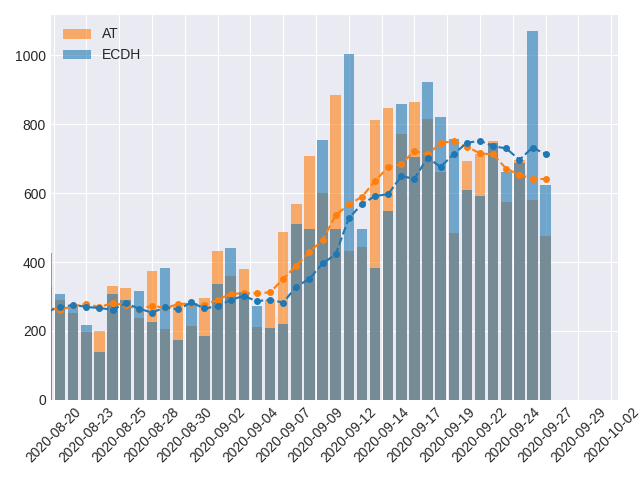

In [26]:
f,ax = plt.subplots()
# ax.bar(df_at.time, df_at['tägliche Erkrankungen'],label='recorded',  alpha=0.6, color='C1')

ax.plot(df_at.time, df_at['tägliche Erkrankungen'].rolling(7).mean(),  marker='o', markersize=4, linestyle='--', color='C1')

ax.bar(df_at.time, df_at['tägliche Erkrankungen'],label='AT',  alpha=0.6, color='C1')
selection = df[df.geoId=='AT'].sort_values(by=['year','month','day'], ascending=True)
ax.bar(selection.dateRep, selection['cases'],label='ECDH',  alpha=0.6, color='C0')
ax.plot(selection.dateRep, selection['cases'].rolling(7).mean(), marker='o', markersize=4, linestyle='--',color='C0')
# plt.yscale('log')

ax.xaxis.set_major_locator(plt.MaxNLocator(20));

plt.xticks(rotation=45);
plt.legend(loc='best')
plt.tight_layout()



### Weekday bias

<IPython.core.display.Javascript object>


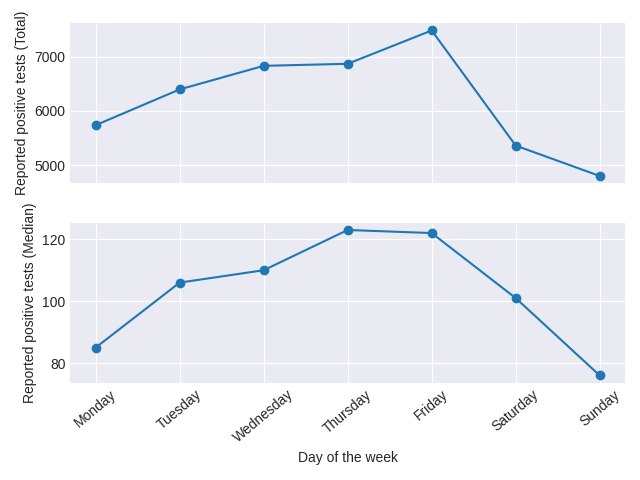

In [27]:
f, ax = plt.subplots(nrows=2, sharex=True)
df_at.groupby(['weekday']).sum()['tägliche Erkrankungen'].plot(ax=ax[0], marker='o')
ax[0].set_ylabel('Reported positive tests (Total)')
df_at.groupby(['weekday']).median()['tägliche Erkrankungen'].plot(ax=ax[1], marker='o')
ax[1].set_ylabel('Reported positive tests (Median)')
ax[1].set_xlabel('Day of the week')
ax[1].set_xticks([0,1,2,3,4,5,6])
ax[1].set_xticklabels(WEEKDAYS, rotation=40)
plt.tight_layout()

# India

<IPython.core.display.Javascript object>


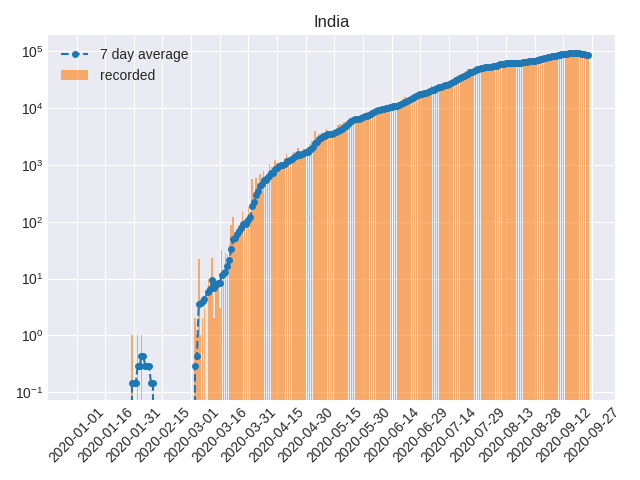

In [17]:
plot_country('IN', log=LOG_PLOT);

# USA

<IPython.core.display.Javascript object>


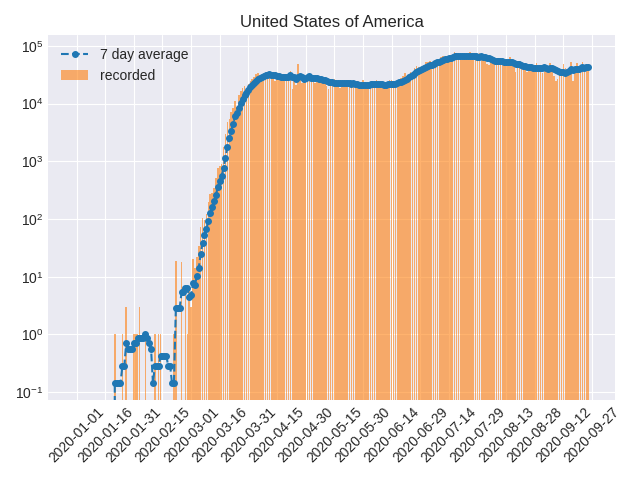

In [18]:
plot_country('US', log=LOG_PLOT);


# Germany

<IPython.core.display.Javascript object>


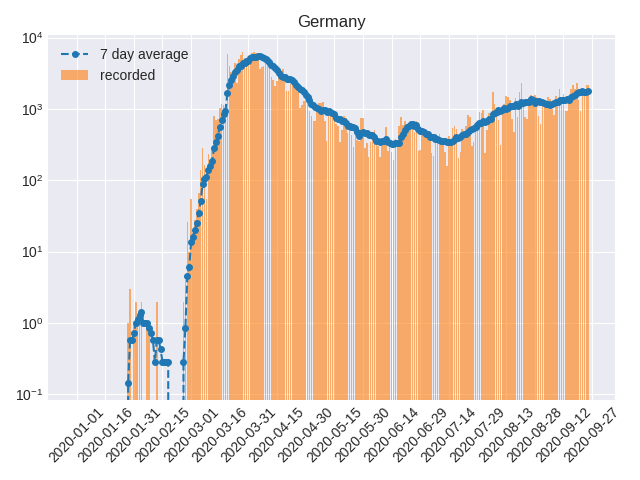

In [19]:
plot_country('DE', log=LOG_PLOT);

## UK

<IPython.core.display.Javascript object>


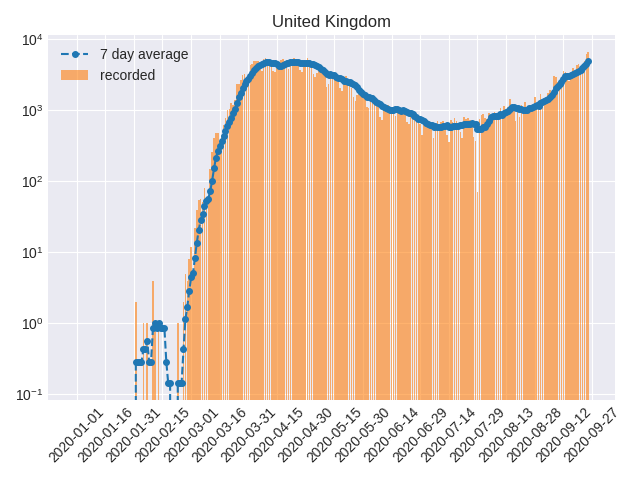

In [20]:
plot_country('UK', log=LOG_PLOT);

# China

<IPython.core.display.Javascript object>


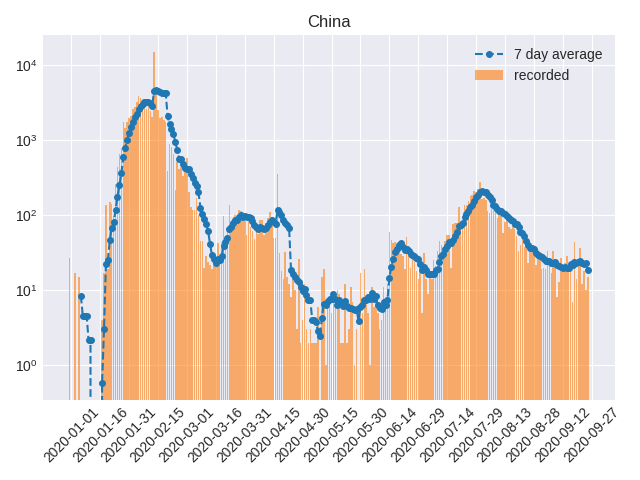

In [21]:
plot_country('CN', log=LOG_PLOT);


# Commit and Push

In [22]:
%cd Documents/code/covid19/
now = datetime.now()
commit_message = "Last run on " + now.strftime('%Y-%m-%d %H:%M')
commit_message
! echo $commit_message > commit_message.txt
! git add .
! git commit -F commit_message.txt
! git push


[Errno 2] No such file or directory: 'Documents/code/covid19/'
/home/gythaogg/Documents/code/covid19/notebooks
[develop 1240865] Last run on 2020-09-25 16:32
 2 files changed, 28 insertions(+), 16 deletions(-)
Enumerating objects: 9, done.
Counting objects: 100% (9/9), done.
Delta compression using up to 16 threads
Compressing objects: 100% (5/5), done.
Writing objects: 100% (5/5), 887 bytes | 887.00 KiB/s, done.
Total 5 (delta 2), reused 0 (delta 0)
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To github.com:gythaogg/covid19.git
   fe322b7..1240865  develop -> develop
